# **Identificación de Imágenes Auténticas y Sintéticas : Abordando los Desafíos de las Imágenes Sintéticas en la Sociedad Actual**

**Contenido**
1. [Configuración del Entorno](#title1)
2. [Construcción del Conjunto de Datos](#title2)
3. [Creación del Modelo](#title3)

## Configuración del Entorno<a name="title1"></a>

In [1]:
import tensorflow as tf
print(tf.config.experimental.list_physical_devices("GPU"))
print(tf.__version__)
# Para limitar la memoria que usa la GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar TensorFlow para que solo utilice la GPU si es necesario
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Configuración de GPU completada")
    except RuntimeError as e:
        print(e)
# Verifica que la GPU está disponible
print("¿GPU está disponible?:", tf.config.list_physical_devices('GPU'))
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import gc
import tensorflow as tf
from keras import backend as K

# Limpiar la memoria del backend
K.clear_session()
# Forzar la recolección de basura
gc.collect()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0
Configuración de GPU completada
¿GPU está disponible?: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


0

In [2]:
# Limpiar la memoria del backend
K.clear_session()
# Forzar la recolección de basura
gc.collect()

105

In [3]:
# Importar todas las librerías de uso.
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()


## Construcción del Conjunto de Datos y Preprocesandolos<a name="title2"></a>

Fuente: https://www.kaggle.com/datasets/kaustubhdhote/human-faces-dataset & https://www.kaggle.com/datasets/hamzaboulahia/hardfakevsrealfaces/code

In [4]:

# Parámetros
batch_size = 32
img_height = 224  # Requerido por EfficientNetB0
img_width = 224
initial_epochs = 10
fine_tune_epochs = 10

# Directorio de datos
data_folder = './Data/All'

# Cargar el dataset completo
full_dataset = image_dataset_from_directory(
    data_folder,
    image_size=(img_height, img_width),
    batch_size=None,  # Cargar todas las imágenes individualmente
    shuffle=True,
    seed=123  # Semilla para reproducibilidad
)

# Obtener el tamaño total del dataset
dataset_size = full_dataset.cardinality().numpy()

# Definir tamaños para entrenamiento, validación y prueba
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

# Dividir el dataset
train_dataset = full_dataset.take(train_size)
remaining = full_dataset.skip(train_size)
validation_dataset = remaining.take(val_size)
test_dataset = remaining.skip(val_size)

# Agrupar los datasets
train_dataset = train_dataset.batch(batch_size)
validation_dataset = validation_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Capturar class_names
class_names = full_dataset.class_names
print("Clases:", class_names)

# Aplicar prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 10919 files belonging to 2 classes.
Clases: ['Fake', 'Real']


In [5]:
# Definir aumento de datos
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1),
])

# Cargar el modelo base preentrenado sin las capas superiores
base_model = EfficientNetB0(input_shape=(img_height, img_width, 3),
                            include_top=False,
                            weights='imagenet')
# Congelar las capas del modelo base para evitar entrenarlas inicialmente
base_model.trainable = False

# Crear la cabecera personalizada para nuestro problema
global_average_layer = layers.GlobalAveragePooling2D()
prediction_layer = layers.Dense(1, activation='sigmoid')  # Usar sigmoid para clasificación binaria

# Modelo<a name="title3"></a>



In [6]:
# Construcción del modelo
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)  # Preprocesamiento específico de EfficientNetB0
x = base_model(x, training=False)
x = global_average_layer(x)
# Incrementar Dropout y Regularización
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005))(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               163968    
                                                             

In [7]:
# Calcular pesos de clase
y_train = np.concatenate([y for x, y in train_dataset], axis=0)
class_weights_values = class_weight.compute_class_weight('balanced',
                                                         classes=np.unique(y_train),
                                                         y=y_train)
class_weights = dict(enumerate(class_weights_values))
print(f"Pesos de clase: {class_weights}")

# Definir callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Entrenar el modelo con pesos de clase y callbacks
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=initial_epochs,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

# Fine-Tuning: Descongelar más capas del modelo base
base_model.trainable = True
fine_tune_at = 100  # Ajusta este valor según la arquitectura específica

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compilar el modelo nuevamente con una tasa de aprendizaje más baja
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Continuar el entrenamiento
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)


Pesos de clase: {0: 1.0294989224137931, 1: 0.9721444924955482}
Epoch 1/10
239/239 [==============================] - 115s 430ms/step - loss: 0.5531 - accuracy: 0.9371 - val_loss: 0.2354 - val_accuracy: 0.9658 - lr: 0.0010
Epoch 2/10
239/239 [==============================] - 105s 438ms/step - loss: 0.2181 - accuracy: 0.9568 - val_loss: 0.1782 - val_accuracy: 0.9670 - lr: 0.0010
Epoch 3/10
239/239 [==============================] - 103s 431ms/step - loss: 0.1804 - accuracy: 0.9627 - val_loss: 0.1324 - val_accuracy: 0.9829 - lr: 0.0010
Epoch 4/10
239/239 [==============================] - 102s 426ms/step - loss: 0.1672 - accuracy: 0.9648 - val_loss: 0.1439 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 5/10
239/239 [==============================] - 106s 442ms/step - loss: 0.1560 - accuracy: 0.9695 - val_loss: 0.1370 - val_accuracy: 0.9743 - lr: 0.0010
Epoch 6/10
239/239 [==============================] - 105s 439ms/step - loss: 0.1526 - accuracy: 0.9681 - val_loss: 0.1184 - val_accuracy: 0.9

52/52 [==============================] - 5s 40ms/step
Umbral Óptimo: 0.0001517685450380668


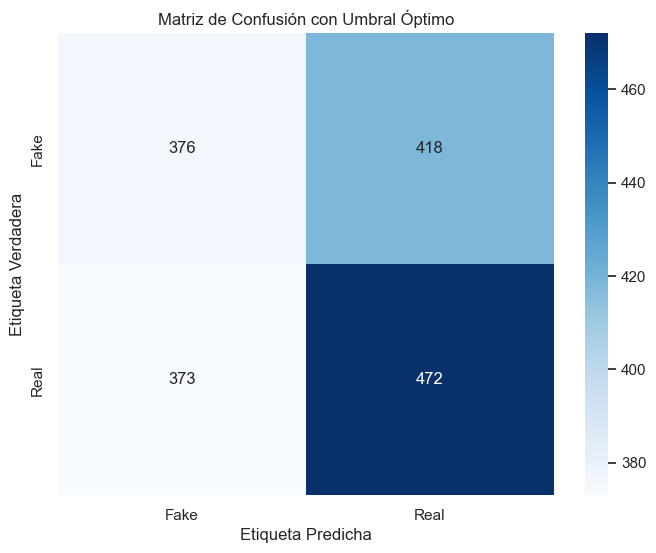


Reporte de Clasificación con Umbral Óptimo:
              precision    recall  f1-score   support

        Fake       0.50      0.47      0.49       794
        Real       0.53      0.56      0.54       845

    accuracy                           0.52      1639
   macro avg       0.52      0.52      0.52      1639
weighted avg       0.52      0.52      0.52      1639

Precisión Global con Umbral Óptimo: 0.5173886516168396


In [10]:
# Métricas
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
predictions = model.predict(test_dataset).ravel()

# Ajustar el umbral óptimo
fpr, tpr, thresholds = roc_curve(true_labels, predictions)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Umbral Óptimo: {optimal_threshold}")

# Aplicar el umbral óptimo
predicted_labels_optimal = (predictions > optimal_threshold).astype(int)

# Matriz de Confusión con umbral óptimo
conf_matrix = confusion_matrix(true_labels, predicted_labels_optimal)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión con Umbral Óptimo')
plt.show()

# Reporte de Clasificación con umbral óptimo
print("\nReporte de Clasificación con Umbral Óptimo:")
print(classification_report(true_labels, predicted_labels_optimal, target_names=class_names))

# Precisión Global con umbral óptimo
accuracy_optimal = accuracy_score(true_labels, predicted_labels_optimal)
print(f"Precisión Global con Umbral Óptimo: {accuracy_optimal}")

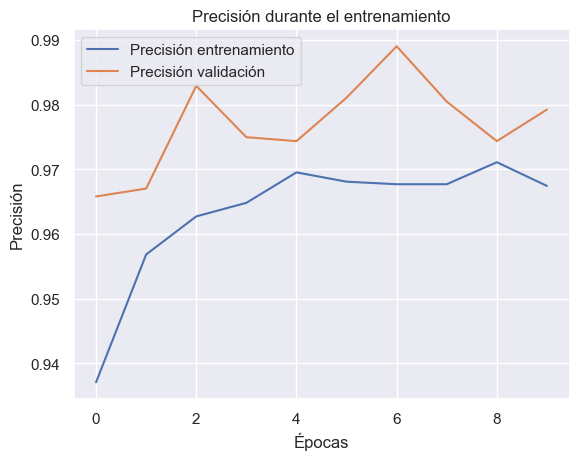

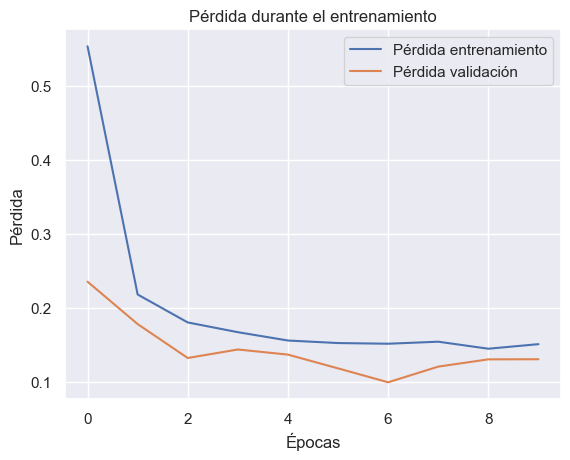

In [11]:
# Visualizar los resultados de entrenamiento
plt.figure()
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión durante el entrenamiento')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida durante el entrenamiento')
plt.legend()
plt.show()

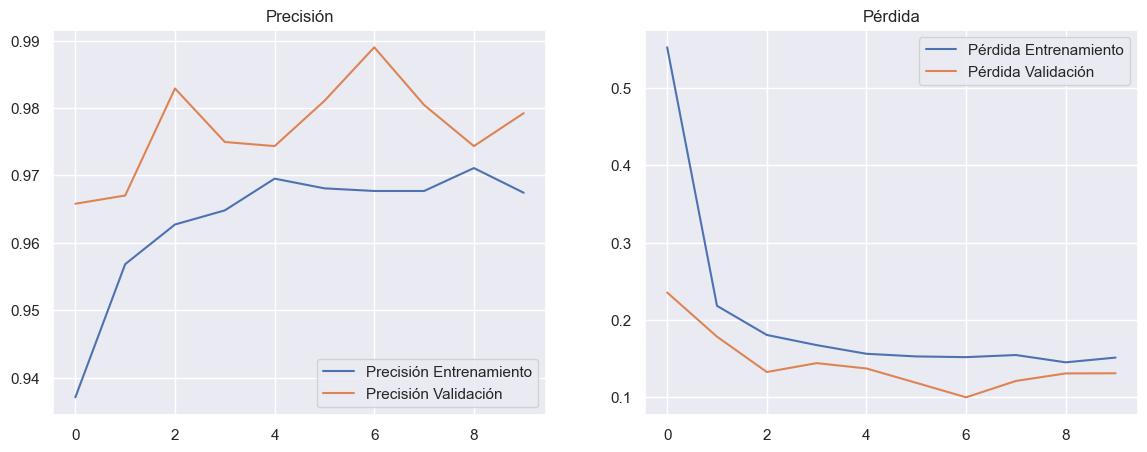

In [12]:
def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Precisión Entrenamiento')
    plt.plot(epochs_range, val_acc, label='Precisión Validación')
    plt.legend(loc='lower right')
    plt.title('Precisión')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Pérdida Entrenamiento')
    plt.plot(epochs_range, val_loss, label='Pérdida Validación')
    plt.legend(loc='upper right')
    plt.title('Pérdida')
    plt.show()

plot_metrics(history)
